In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd

In [2]:
np.random.seed(33)
k=8
centers=np.random.uniform(0,8,(k,2))
sigma=0.7


def f(x):
    x=np.asarray(x).reshape(2,)
    diffs=x-centers
    r2=np.sum(diffs**2,axis=1)
    exps=np.exp(-0.5/sigma*r2)
    return -np.sum(exps)

def grad(x):
    x=np.asarray(x).reshape(2,)
    diffs=x-centers
    r2=np.sum(diffs**2,axis=1)
    exps=np.exp(-0.5/sigma*r2)
    return (1.0/sigma)*np.sum(exps[:,None]*diffs,axis=0)

def hess(x):
    x=np.asarray(x).reshape(2,)
    diffs=x-centers
    r2=np.sum(diffs**2,axis=1)
    exps=np.exp(-0.5/sigma*r2)
    H=np.zeros((2,2))
    for ei,d in zip(exps,diffs):
        H+= (1.0/sigma)*ei*(np.eye(2)-(1.0/sigma)*np.outer(d,d))
    return H

def gradient_descent(x0,maxiter=1000,tol=1e-6,alpha0=1.0,c=1e-4,rho=0.5):
    x=np.asarray(x0).astype(float)
    path=[x.copy()]
    for i in range(maxiter):
        g=grad(x)
        ng=np.linalg.norm(g)
        if ng<tol:
            break
        alpha=alpha0
        fx=f(x)
        while True:
            xn=x-alpha*g
            if f(xn)<=fx-c*alpha*ng*ng or alpha<1e-8:
                break
            alpha*=rho
        x=xn
        path.append(x.copy())
    return x,np.array(path)

def newton_method(x0,maxiter=200,tol=1e-6):
    x=np.asarray(x0).astype(float)
    path=[x.copy()]
    for i in range(maxiter):
        g=grad(x)
        ng=np.linalg.norm(g)
        if ng<tol:
            break
        H=hess(x)
        eigs=np.linalg.eigvalsh(H)
        min_eig=eigs[0]
        if min_eig<=0:
            H=H+(-(min_eig)+1e-6)*np.eye(2)
        try:
            p=np.linalg.solve(H,g)
        except np.linalg.LinAlgError:
            p=g
        alpha=1.0
        fx=f(x)
        while True:
            xn=x-alpha*p
            if f(xn)<=fx-1e-4*alpha*np.dot(g,p) or alpha<1e-8:
                break
            alpha*=0.5
        x=xn
        path.append(x.copy())
    return x,np.array(path)

def run_scipy_bfgs(x0):
    path=[]
    def cb(xk):
        path.append(xk.copy())
    res=minimize(lambda x: f(x), x0, method='BFGS', jac=lambda x: grad(x), callback=cb, options={'gtol':1e-6,'maxiter':1000, 'disp':False})
    full_path=[np.asarray(x0)]+path
    return res.x,np.array(full_path)

n_starts=30
starts=np.random.uniform(0,8,(n_starts,2))
results=[]


for x0 in starts:
    x_gd,path_gd=gradient_descent(x0)
    results.append({'method':'GD','x':x_gd,'f':f(x_gd),'path':path_gd,'x0':x0})
for x0 in starts:
    x_nm,path_nm=newton_method(x0)
    results.append({'method':'Newton','x':x_nm,'f':f(x_nm),'path':path_nm,'x0':x0})
for x0 in starts[:20]:
    x_bfgs,path_bfgs=run_scipy_bfgs(x0)
    results.append({'method':'BFGS','x':x_bfgs,'f':f(x_bfgs),'path':path_bfgs,'x0':x0})

def cluster_minima(points,tol=1e-3):
    clusters=[]
    counts=[]
    for p in points:
        found=False
        for i,c in enumerate(clusters):
            if np.linalg.norm(p-c)<=tol:
                counts[i]+=1
                found=True
                break
        if not found:
            clusters.append(p.copy())
            counts.append(1)
    return np.array(clusters),np.array(counts)


   min_id         x         y      fval  count
0       0  7.552860  2.879479 -1.143981      7
1       1  1.521428  3.258557 -1.323195     22
2       2  7.090962  1.793397 -1.131310     16
3       3  3.153316  2.233733 -1.083042     19
4       4  5.484914  3.864108 -1.024793     12
5       5  0.733188  7.745671 -1.562090      3
6       6  7.204504  7.760088 -0.000003      1


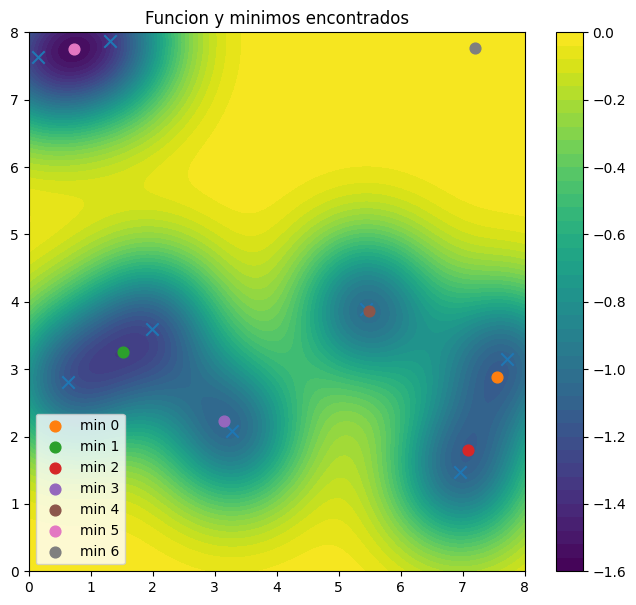

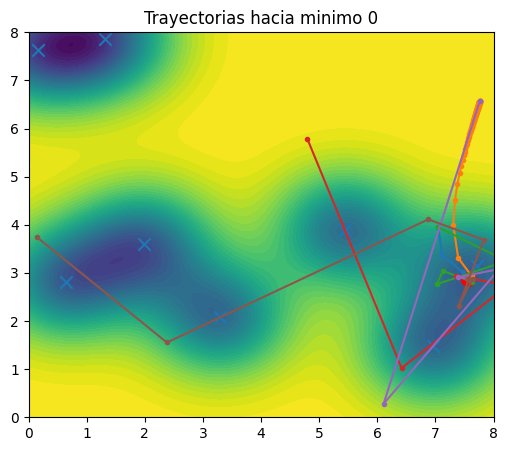

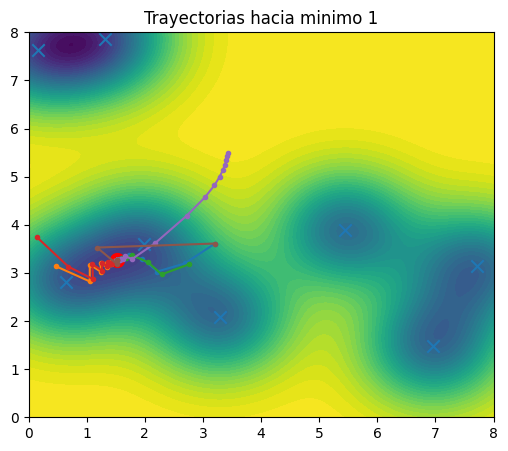

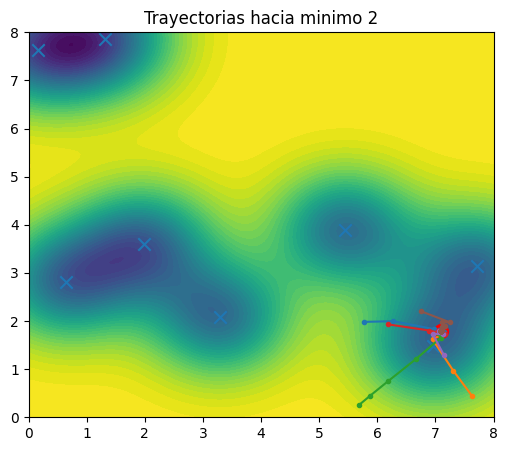

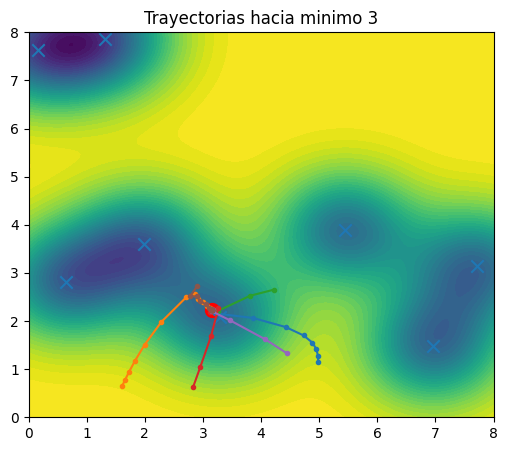

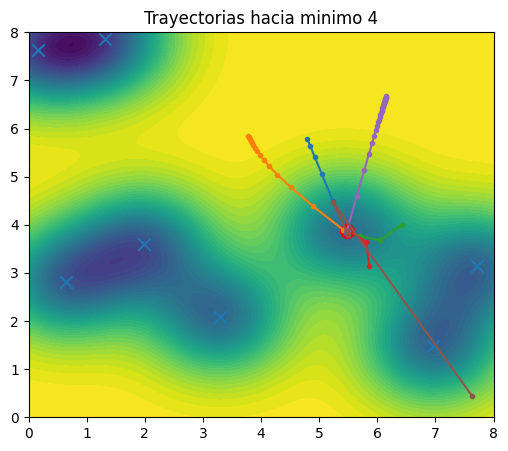

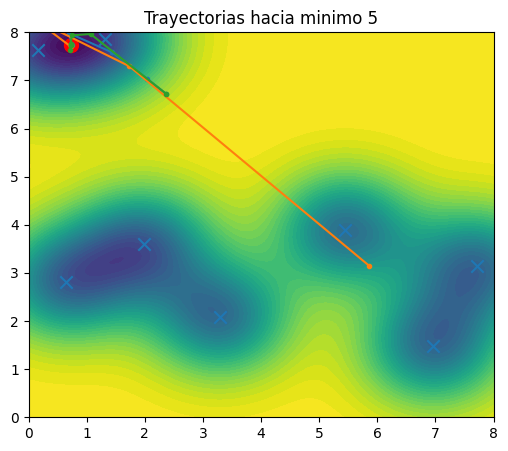

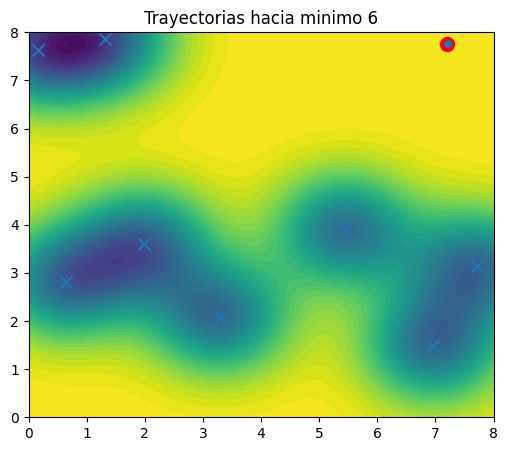

Centros (congelados):
[[1.98808102 3.59980337]
 [3.28752642 2.08239753]
 [6.96316551 1.48031942]
 [0.1572914  7.62601625]
 [5.44360644 3.89270501]
 [7.72021456 3.14718991]
 [0.63646057 2.8112594 ]
 [1.3090813  7.86533457]]
sigma= 0.7


In [3]:
# Mostrar los resultados
final_points=np.array([r['x'] for r in results])
unique_mins,counts=cluster_minima(final_points,tol=1e-3)
vals=[f(p) for p in unique_mins]
df=pd.DataFrame({'min_id':np.arange(len(unique_mins)),'x':unique_mins[:,0],'y':unique_mins[:,1],'fval':vals,'count':counts})
print(df)

nx=200
xs=np.linspace(0,8,nx)
ys=np.linspace(0,8,nx)
XX,YY=np.meshgrid(xs,ys)
ZZ=np.zeros_like(XX)
for i in range(nx):
    for j in range(nx):
        ZZ[j,i]=f([XX[j,i],YY[j,i]])

plt.figure(figsize=(8,7))
cs=plt.contourf(XX,YY,ZZ,levels=50)
plt.scatter(centers[:,0],centers[:,1],marker='x',s=80)
plt.colorbar(cs)
for i,(mx,my) in enumerate(unique_mins):
    plt.scatter(mx,my,s=60,label=f'min {i}')
plt.legend()
plt.title('Funcion y minimos encontrados')
plt.xlim(0,8)
plt.ylim(0,8)
plt.show()

for i,(mx,my) in enumerate(unique_mins):
    plt.figure(figsize=(6,5))
    cs=plt.contourf(XX,YY,ZZ,levels=50)
    plt.scatter(centers[:,0],centers[:,1],marker='x',s=80)
    plt.scatter(mx,my,s=100,c='red')
    plotted=0
    for r in results:
        if np.linalg.norm(r['x']-np.array([mx,my]))<=1e-3 and plotted<6:
            path=r['path']
            plt.plot(path[:,0],path[:,1],'-o',markersize=3)
            plotted+=1
    plt.title(f'Trayectorias hacia minimo {i}')
    plt.xlim(0,8)
    plt.ylim(0,8)
    plt.show()

print('Centros (congelados):')
print(centers)
print('sigma=',sigma)